In [6]:
%load_ext autoreload
%autoreload 2


In [7]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/T1.csv")
data.dtypes


Date/Time                        object
LV ActivePower (kW)             float64
Wind Speed (m/s)                float64
Theoretical_Power_Curve (KW)    float64
Wind Direction (°)              float64
dtype: object

In [8]:
maxVal = data["LV ActivePower (kW)"].max()


In [9]:
from attacks import additive, cyclicPhysics, theoreticalPower

added = additive(data["LV ActivePower (kW)"], 200, 0.9) #.clip(upper=maxVal)
falsified_power = cyclicPhysics(data, 200, 10)
theoretical = theoreticalPower(data)

len(data)


50530

In [10]:
def scale(values):
    return values / data["LV ActivePower (kW)"].max()


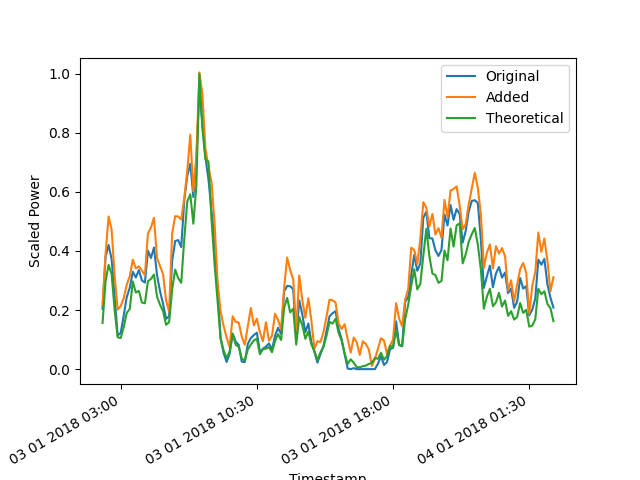

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget

START_PLOT = 300
TO_PLOT = 450

plt.figure()
plt.plot(
    data["Date/Time"][START_PLOT:TO_PLOT],
    scale(data["LV ActivePower (kW)"][START_PLOT:TO_PLOT]),
    label="Original",
)
plt.plot(data["Date/Time"][START_PLOT:TO_PLOT], scale(added[START_PLOT:TO_PLOT]), label="Added")
plt.plot(data["Date/Time"][START_PLOT:TO_PLOT], scale(theoretical[START_PLOT:TO_PLOT]), label="Theoretical")

# plt.plot(data["Date/Time"][:TO_PLOT], deducted[:TO_PLOT], label="Deducted")
# plt.plot(data["Date/Time"][:TO_PLOT], movingAvgAdd[:TO_PLOT], label="Avg Added")

plt.xlabel("Timestamp")
plt.ylabel("Scaled Power")


plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=TO_PLOT // 10))
plt.legend()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KW),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


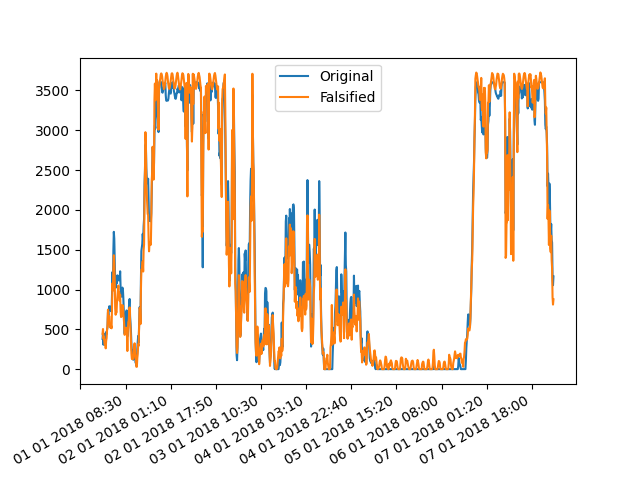

In [12]:
TO_PLOT = 1000

plt.figure()
plt.plot(
    data["Date/Time"][:TO_PLOT],
    data["LV ActivePower (kW)"][:TO_PLOT],
    label="Original",
)

plt.plot(
    data["Date/Time"][:TO_PLOT],
    falsified_power[:TO_PLOT],
    label="Falsified",
)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=TO_PLOT // 10))
plt.legend()

data


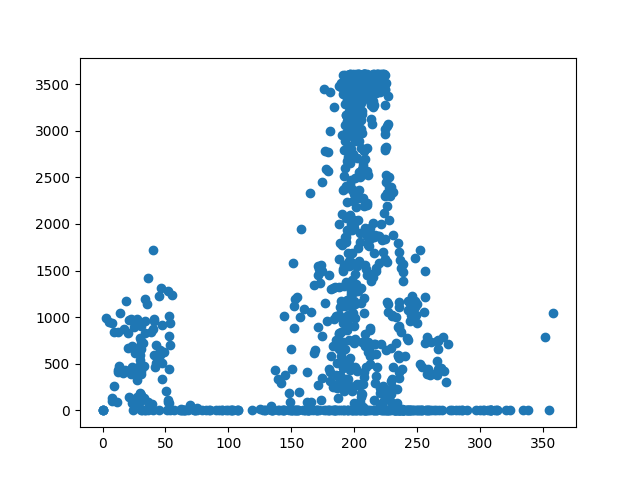

In [13]:
TO_PLOT = 1000

plt.figure()
plt.scatter(
    data["Wind Direction (°)"][:TO_PLOT],
    data["LV ActivePower (kW)"][:TO_PLOT],
)
# 0-55
# 180-230


In [16]:
from torch.utils.data import DataLoader
from data import WindowSelector, NormalizedWindowSelector, ChanneledWindowSelector
import torch.nn as nn
import torch.optim as optim
import torch
import pandas as pd

torch.set_default_dtype(torch.float64)

TRAINING = 40000
window = 34
batch_size = 64

# scaledPower = scale(np.asarray(data[["LV ActivePower (kW)", "Theoretical_Power_Curve (KW)"]]))
# print(scaledPower)
scaledPower = scale(data[["LV ActivePower (kW)"]].to_numpy())

training_loader = DataLoader(
    ChanneledWindowSelector(
        scaledPower[:TRAINING],
        window,
    ),
    batch_size,
    shuffle=True,
    drop_last=True,
)
testing_loader = DataLoader(
    ChanneledWindowSelector(
        scaledPower[TRAINING:],
        window,
    ),
    batch_size,
    drop_last=True,
)


In [17]:
from AER_Custom import AER

model = AER(64, signal_shape=(32, 1), latent_shape=8)


In [ ]:

from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format("png")

# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(
    model.aer,
    input_size=(64, 32, 1),
    device="meta",
    graph_name="AER"
)
model_graph.visual_graph.node_attr["fontname"] = "Helvetica"

model_graph.visual_graph


In [ ]:
model.train(training_loader, testing_loader, 1000)


Epoch [1/1000] | 0.1346744462286039
Validation loss: 0.0962879813850413
Epoch [2/1000] | 0.09329317629294494
Epoch [3/1000] | 0.09146444632391326
Epoch [4/1000] | 0.09071149425521749
Epoch [5/1000] | 0.09026922522432819
Epoch [6/1000] | 0.0902565962440853
Epoch [7/1000] | 0.09002473919681114
Epoch [8/1000] | 0.08998237109136396
Epoch [9/1000] | 0.08979588232294931
Epoch [10/1000] | 0.0897903969139585
Epoch [11/1000] | 0.08982083559112262
Validation loss: 0.08894033960575627
Epoch [12/1000] | 0.08966627372133641
Epoch [13/1000] | 0.08973224610715773
Epoch [14/1000] | 0.08961201270177392
Epoch [15/1000] | 0.08958244953254188
Epoch [16/1000] | 0.08963214644526425
Epoch [17/1000] | 0.08948392517520858
Epoch [18/1000] | 0.08949312934886762
Epoch [19/1000] | 0.08942836178004294
Epoch [20/1000] | 0.0894010021801625
Epoch [21/1000] | 0.08940365311364729
Validation loss: 0.08823402430234002
Epoch [22/1000] | 0.08922275059175304
Epoch [23/1000] | 0.08920117079240605
Epoch [24/1000] | 0.089071773

KeyboardInterrupt: 

In [ ]:
torch.save(model.aer.state_dict(), "./models/AER_Final1.zip")


In [18]:
import torch
model.aer.load_state_dict(torch.load("./models/AER_Final1.zip"))


<All keys matched successfully>

In [19]:
START = TRAINING
END = -1

anomalyScoresAdded = model.anomalyScores(
    np.array(
        scale(added[START:END]),
    ),
    scale(theoretical[START:END]).to_numpy(),
)

anomalyScoresReal = model.anomalyScores(
    np.array(
        scale(data["LV ActivePower (kW)"][START:END]),
    ),
    scale(theoretical[START:END]).to_numpy(),
)


Do these ranges look right?!
0.005735855078097127 1.1004812788930927
0.0 1.0 


Do these ranges look right?!
-0.00029765419545627964 0.9960613479797036
0.0 1.0 




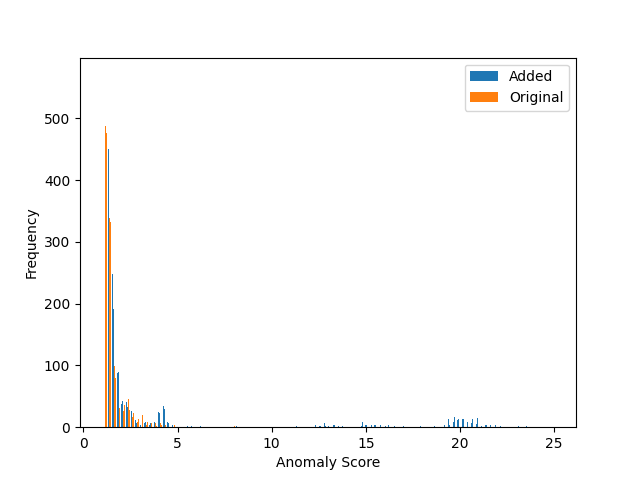

In [25]:
info = ("Prediction Score", "Loss", "Latent", "Reconstruction Error")
# for i in range(2, 6):
#     plt.figure()
#     plt.plot(
#     data["Date/Time"][START:END],
#      anomalyScoresReal[i],
#     label="Original",
#     )
#     plt.plot(
#         data["Date/Time"][START:END],
#         anomalyScoresAdded[i],
#         label="Added",
#     )
#     plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=(10000) // 5))

#     plt.legend()

plt.figure()
plt.hist(
    [anomalyScoresAdded[0], anomalyScoresReal[0]],
    label=[f"Added", f"Original"],
    bins=1000,
)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()

# plt.figure()
# plt.plot(
#     data["Date/Time"][START:END],
#     scaledPower[:, 0][START:END],
#     label="Original",
# )
# plt.plot(
#     data["Date/Time"][START:END],
#     scale(added[START:END]),
#     label="Added",
# )

# plt.plot(
#     data["Date/Time"][START:END],
#     anomalyScoresReal[1],
#     label="Reconstructed Original",
# )
# plt.plot(
#     data["Date/Time"][START:END],
#     anomalyScoresAdded[1],
#     label="Reconstructed Added",
# )
# # plt.plot(
# #     data["Date/Time"][START:END],
# #     scale(theoretical[START:END]),
# #     label="Theoretical",
# # )
# plt.xlabel("Timestamp")
# plt.ylabel("Scaled Power")
# plt.gcf().autofmt_xdate()
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=(10000) // 5))
# plt.legend()

# plt.figure()
# plt.plot(
#     data["Date/Time"][START:END],
#     anomalyScoresReal[0],
#     label="Original Scores",
# )
# plt.plot(
#     data["Date/Time"][START:END],
#     anomalyScoresAdded[0],
#     label="Added Scores",
# )


# plt.xlabel("Timestamp")
# plt.ylabel("Anomaly Score")
# plt.gcf().autofmt_xdate()
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=(10000) // 5))
# plt.legend()

In [21]:
for scores in [anomalyScoresAdded[0], anomalyScoresReal[0]]:
    predictedAnomaly = np.zeros_like(data["LV ActivePower (kW)"][START:END])

    window_size = 500
    step_size =1 # len(scores) //(3 * 10)
    is_anomaly = np.zeros(len(scores))
    for i in range(0, len(scores) - window_size, step_size):
        predictedAnomaly[i : i + window_size] += scores[i : i + window_size].min() > 1.13

    print("Anomaly pct:", np.count_nonzero(predictedAnomaly > 450) / len(predictedAnomaly))


Anomaly pct: 0.914426821160604
Anomaly pct: 0.0
